In [1]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
from math import floor
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
nlp = spacy.load('en_core_web_lg')

OSError: [E050] Can't find model 'en_core_web_lg'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [3]:
bib = pd.read_csv('bibliography/everyone.csv')

In [4]:
authorDfList = list(bib.groupby('author'))

In [5]:
authorDfDict = {author: df for author, df in authorDfList}

In [6]:
authorList = list(authorDfDict.keys())

In [7]:
class textPieces(): 
    def __init__(self, author, df, sample=True, pieces=2): 
        self.author = author
        self.df = df
        self.labels = []
        for i, row in df.iterrows():
            try: 
                age = int(row.age)
            except: 
                age = str(row.age)
            try:
                ytd = int(row.yearsToDeath)
            except: 
                ytd = str(row.yearsToDeath)
            self.labels.append('%d-%s-%s-%s' % (row.date, age, ytd, row.title))
        self.texts = [self.getText(bookID) for bookID in df['id']]
        # Prune those where texts can't be found
        prunedTexts, prunedLabels = [], []
        for label, text in zip(self.labels, self.texts): 
            if text is not None: 
                prunedTexts.append(text)
                prunedLabels.append(label)
        self.texts = prunedTexts
        self.labels = prunedLabels
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
#         print('Using texts: ', self.labels)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.pieces = []
            self.makePieces(self.labels, self.samples, pieces)
        else: 
            self.pieces = self.texts
        
    def getText(self, bookID):
        database = 'sqlite:////home/jon/Code/gitenberg-scrape/pg-text-7.db'
        query = 'select text from text where id = ' + str(round(float(bookID)))
        df = pd.read_sql(query, database)
        if len(df) > 0: 
            return df.text[0]
        else:
            return None
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, labels, samples, n): 
        pieceSize = self.lowestLength / n
        self.labels = []
        for label, sample in zip(labels, samples): 
            for i in range(n):
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [8]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        self.pieceTdds = []
        for label in self.labels:
            try:
                tdd = int(label.split('-')[2])
            except: 
                tdd = 0
            self.pieceTdds.append(tdd)
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        self.tddCats = [self.getTddCat(tdd) for tdd in self.pieceTdds]
    
    def getTddCat(self, tdd):
        """ Map time to death to three categories: 
        very late (5 years to death), late (ten years to death), other."""
        vLate = {tdd: 2 for tdd in range(5)}
        late = {tdd: 1 for tdd in range(5, 10)}
        other = {tdd: 0 for tdd in range(10, 120)}
        tddDict = {**vLate, **late, **other}
        return tddDict[tdd]
        
#     def vectorize(self): 
#         tfidf = TfidfVectorizer(use_idf=False, max_features=400)
#         matrix = tfidf.fit_transform(self.docs).todense()
#         features = tfidf.get_feature_names()
#         return features, matrix
    
    def vectorize(self):
        sdocs = [nlp(doc) for doc in self.docs]
        return np.array([sdoc.vector for sdoc in sdocs])
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
        
    def doLSA(self):
        lsa = TruncatedSVD(n_components=5)
        return lsa.fit_transform(self.matrix)
        
    def plotPCA(self, tSNE=False, labels=True, saveTo=False, clustering='bgm'): 
        if tSNE: 
            pcaTable = self.doTSNE()
        else: 
            pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
#         print('Adjusted rand score, Kmeans: ', randK)
#         print('Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
#         print('Adjusted mutual info score, Kmeans: ', randK)
#         print('Adjusted mutual info score, BGM: ', randB)
        
    def periodicity(self): 
        return adjusted_rand_score(self.categories, self.bgm())
    
    def categorize(self, cats):
        pointsDict = {cat: [] for cat in set(cats)}
        for point, cat in zip(self.doPCA(), cats):
            pointsDict[cat].append(point)
        return pointsDict
                              
    def categorizeBGM(self):
        return self.categorize(self.bgm())
    
    def categorizePoints(self):
        return self.categorize(self.categories)
    
    def categorizeTdd(self):
        return self.categorize(self.tddCats)
    
    def centroids(self, cats): 
        centroidsDict = {}
        for key, val in cats.items():
            centroid = np.mean(val, axis=0)
            centroidsDict[key] = centroid
        return centroidsDict
    
    def centroidsBGM(self): 
        return self.centroids(self.categorizeBGM())
    
    def centroidsCats(self): 
        return self.centroids(self.categorizePoints())
        
    def centroidsTddCats(self):
        return self.centroids(self.categorizeTdd())
    
    def lateDistinctiveness(self): 
        return np.linalg.norm(self.centroidsCats()[2])
    
    def earlyDistinctiveness(self):
        return np.linalg.norm(self.centroidsCats()[0])
    
    def lateness(self):
        return self.lateDistinctiveness() - self.earlyDistinctiveness()
    
    def lateDistinctivenessTdd(self):
        if 2 in self.centroidsTddCats(): 
            return np.linalg.norm(self.centroidsTddCats()[2])
        else:
            return 0
    
    def earlyDistinctivenessTdd(self):
        if 0 in self.centroidsTddCats():
            return np.linalg.norm(self.centroidsTddCats()[0])
        else:
            return 0
    
    def tddLateness(self):
        return self.lateDistinctivenessTdd() - self.earlyDistinctivenessTdd()

In [9]:
def doAnalysis(author):
    df = authorDfDict[author]
    pieces = textPieces(author, df)
    analysis = authorAnalysis(pieces.labels, pieces.pieces)
    #print(analysis.plotPCA())
    print("Lateness: %s TDDLateness: %s Periodicity: %s" % 
          (analysis.lateness(), analysis.tddLateness(), analysis.periodicity()))
    return analysis

In [10]:
testAnalysis = doAnalysis(authorList[0])

Lateness: 0.129855835896 TDDLateness: -0.0584448910277 Periodicity: 0.637563451777


In [11]:
latenesses = {author: [] for author in authorList}
periodicities = {author: [] for author in authorList}
tddLatenesses = {author: [] for author in authorList}

In [12]:
nTrials = 5
for i in range(nTrials):
    for author in authorList:
        print("Analyzing: ", author, " trial: ", i, end='\r')
        analysis = doAnalysis(author)
        latenesses[author].append(analysis.lateness())
        tddLatenesses[author].append(analysis.tddLateness())
        periodicities[author].append(analysis.lateness())

Lateness: 0.0984108931043 TDDLateness: -0.079094237859 Periodicity: -0.130572472594
Lateness: -0.370823444445 TDDLateness: 1.0675996984e-16 Periodicity: -0.0467380720545
Lateness: 0.116714354504 TDDLateness: -4.6315115738e-17 Periodicity: 0.0506329113924
Lateness: -0.0413775286303 TDDLateness: 0.114308968387 Periodicity: 0.482958385633
Lateness: -0.0209568567139 TDDLateness: -0.0062163445224 Periodicity: 0.0865060026096
Lateness: 0.00955198687349 TDDLateness: -8.37664331512e-17 Periodicity: 0.232302357655
Lateness: 0.0113853089498 TDDLateness: -1.18795674002e-16 Periodicity: 0.0777848326033
Lateness: -0.0719481227454 TDDLateness: -7.96420933216e-17 Periodicity: 0.154072981939
Lateness: 0.0563693331199 TDDLateness: -0.0318549303723 Periodicity: 0.388349514563
Lateness: -0.0725467091273 TDDLateness: 0.114587323155 Periodicity: 0.0750713591747
Lateness: -0.014229675898 TDDLateness: 0.199314310141 Periodicity: 0.0144326822723
Lateness: 0.0226073203221 TDDLateness: -6.7556123514e-17 Periodi

Lateness: -0.269512855931 TDDLateness: -0.0279638027911 Periodicity: 0.208347706106
Lateness: -0.0615062530117 TDDLateness: -1.26485424279e-16 Periodicity: 0.235456771247
Lateness: 0.00848646003512 TDDLateness: -7.59108034803e-17 Periodicity: -0.0138158411178
Lateness: 0.0313226410505 TDDLateness: -7.23642661099e-17 Periodicity: 0.0712187958884
Lateness: -0.362588470212 TDDLateness: -0.0070419071687 Periodicity: 0.162423516324
Lateness: 0.0327325312354 TDDLateness: 0.184850342971 Periodicity: -0.0104188961682
Lateness: 0.0282888664976 TDDLateness: -9.40011272954e-17 Periodicity: 0.215223097113
Lateness: 0.0585385291515 TDDLateness: 0.0585385291515 Periodicity: -0.0473482650574
Lateness: -0.0145591798226 TDDLateness: 0.11050203344 Periodicity: 0.0128289783983
Lateness: -0.0254519238924 TDDLateness: -0.00914392728811 Periodicity: 0.080295202952
Lateness: -0.0723915578077 TDDLateness: 0.0513288717913 Periodicity: 0.0619554376159
Lateness: -0.137744167705 TDDLateness: 5.10499584608e-17 Per

In [13]:
meanLatenesses = {author: np.mean(lateList) for author, lateList in latenesses.items()}

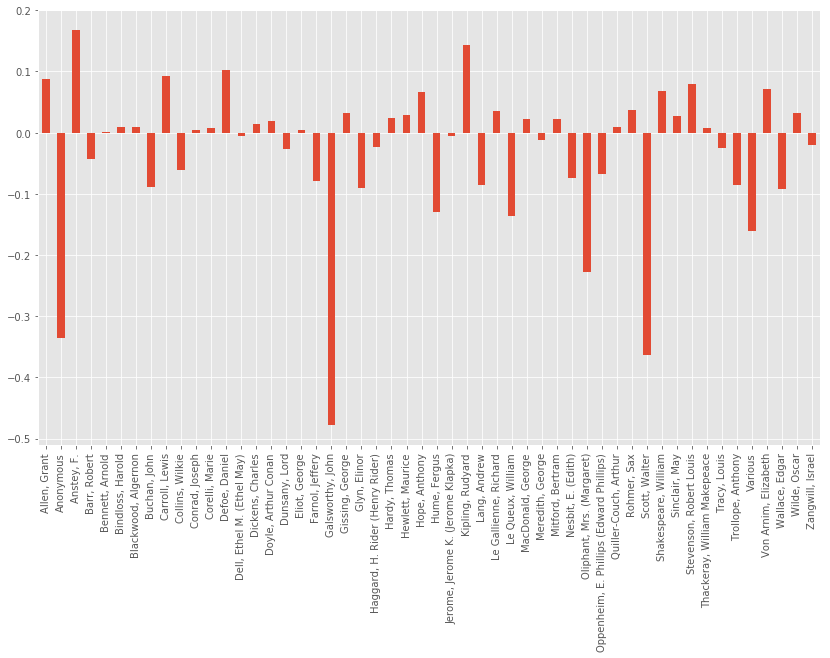

In [23]:
meanLatenessesSeries = pd.Series(meanLatenesses)
meanLatenessesSeries.plot(kind='bar')

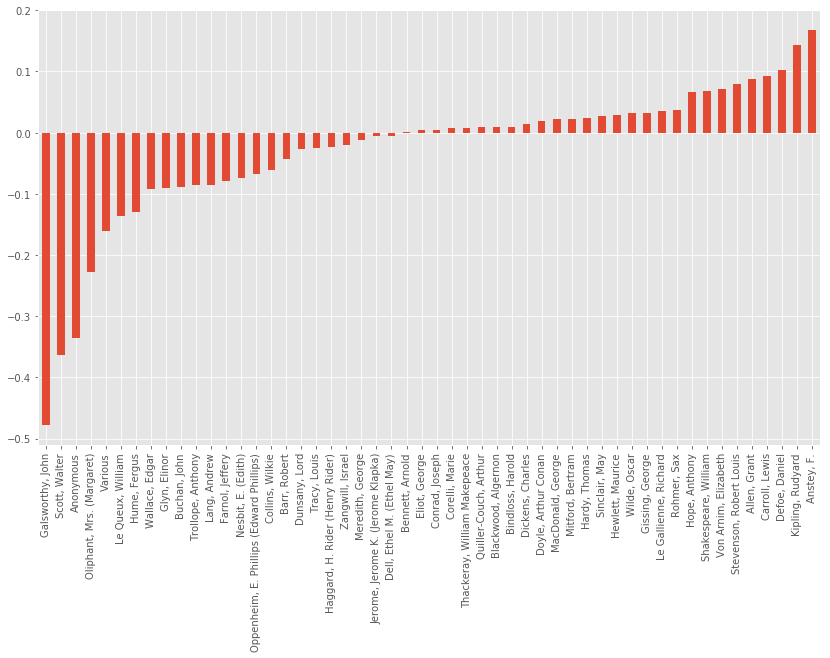

In [24]:
meanLatenessesSeries.sort_values().plot(kind='bar')

In [25]:
meanLatenessesSeries.mean()

-0.028774996776069928

In [26]:
meanPeriodicities = {author: np.mean(pList) for author, pList in periodicities.items()}

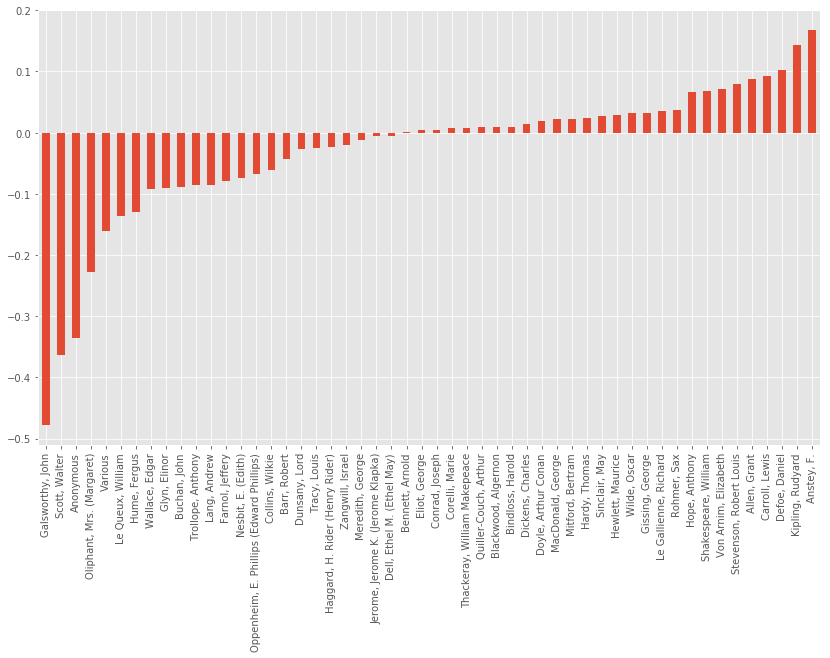

In [31]:
meanPeriodicitiesSeries = pd.Series(meanPeriodicities).sort_values()
meanPeriodicitiesSeries.plot(kind='bar')

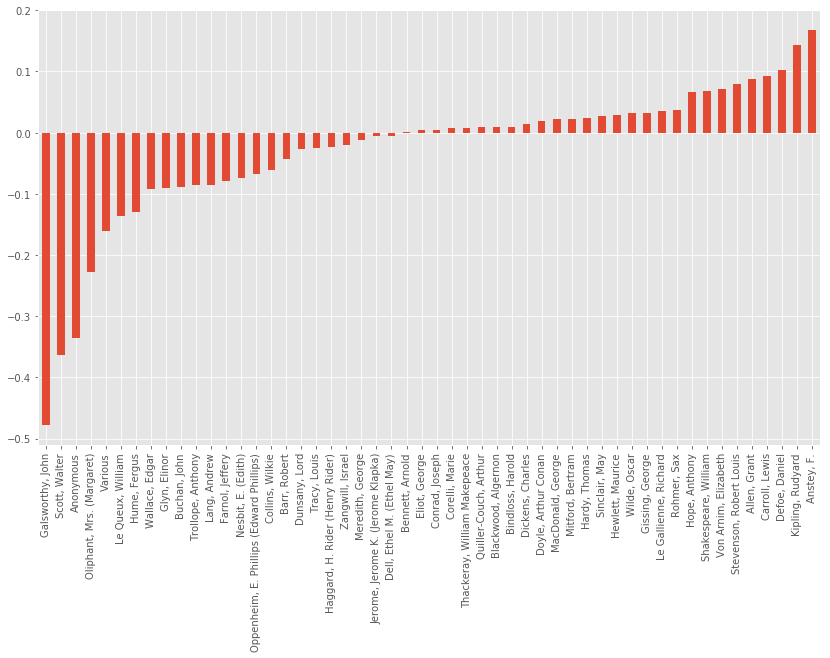

In [28]:
meanPeriodicitiesSeries.sort_values().plot(kind='bar')

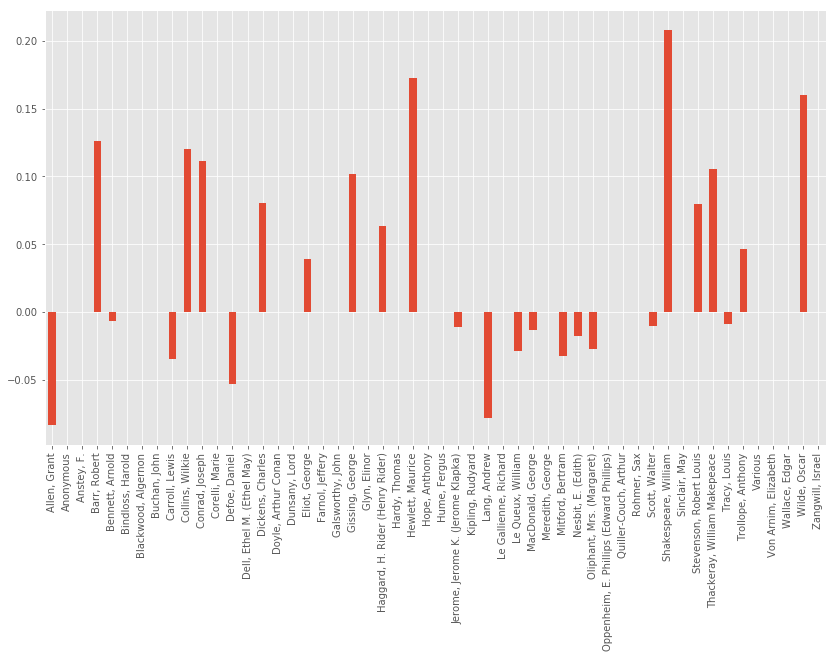

In [29]:
meanTddLatenesses = {author: np.mean(lateList) for author, lateList in tddLatenesses.items()}
meanTddLatenessesSeries = pd.Series(meanTddLatenesses)
meanTddLatenessesSeries.plot(kind='bar')

In [30]:
meanTddLatenessesSeries.mean()

0.019373365700976697